In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
%matplotlib inline

# Importation des données

In [123]:
seuil_detection_fitness=0.005

data = "cleaned"    # "raw" data or "cleaned" data (without dead cells and aberrant growth rates)

if data == "raw":
    file="doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",", 
                          usecols=range(2,1476*3+1,3), 
                          skiprows=[1,2])

elif data == "cleaned":
    file="Modified_data/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",")

growthR_real = growthR_real.to_numpy()
growthR_real[growthR_real<seuil_detection_fitness] = 0

In [124]:
with open('SimulatedData/growthR_sim.npy', 'rb') as f:
    growthR_sim = np.load(f)
with open('SimulatedData/growthR_sim_noisy.npy', 'rb') as f:
    growthR_sim_noise = np.load(f)

Load simulation replicates :

In [211]:
growthR_sim_rep = np.hsplit(np.loadtxt("SimulatedData/growthR_sim_replicates.csv", delimiter=";"), 10)
growthR_sim_noise_rep = np.hsplit(np.loadtxt("SimulatedData/growthR_sim_noise_replicates.csv", delimiter=";"), 10)

# Calcul de Ff

In [244]:
def fourier_inverse_old(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/(n*2*np.pi)]
    return (xi[1]-xi[0])*np.array(res)


def fourier_inverse0(X,Xi,F_Xi):
    print([[np.mean(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi)] for x in X])
    return [np.mean(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def fourier_inverse(X,Xi,F_Xi):
    print(Xi[1]-Xi[0])
    print(np.sum(np.array(F_Xi)*np.exp(1j*x*Xi)))
    return [(Xi[1]-Xi[0])*np.sum(np.array(F_Xi)*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def get_fourier_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*Wt[Wt>0])) for xi in Xi]

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [19]:
def get_axi(wt,ximin,ximax,nbreaks_xi,tmax):
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot_four = ([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    tot_abs = np.log(np.abs(tot_four))
    tot_ang = np.angle(tot_four)
        
    # régression linéaire:
    res=[]
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot_abs)[:,k])
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(range(tmax),np.real(tot_ang)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        res+=[(Xi[k],slope,slope2)]
        #print("pente :",slope, "\tpente angle :",slope2)
    # affichage:
    #plt.plot(range(tmax),tot_abs)
    #plt.grid()
    #plt.legend(["xi="+str(xi) for xi in Xi])
    #plt.xlabel("t")
    #plt.ylabel("ln[Fu_t(xi)]")
    #plt.title(titre)
    #plt.show() 
    return res

# Calcul effectif de la DFE

In [246]:
xmin_reel=-0.1
xmax_reel=0.999
nbreaks_x=500
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(1-x)

In [247]:
lambd=0.32/60 # constante biologique = taux de mutation

La fonction suivante applique la formule de la dfe trouvée avec l'edp :

In [253]:
def get_dfe(wt,ximin,ximax,nbreaks_xi):
    a_xi=[]
    xi=[]
    xi_axi=get_axi(wt,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    y=fourier_inverse_old(lnx,xi,Ff)
    return y

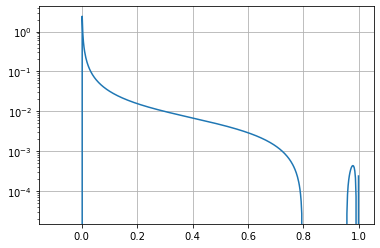

In [254]:
dfeln=get_dfe(growthR_sim,ximin=0,ximax=2,nbreaks_xi=100)

# on transforme f densité de ln(1-s) en g densité de 1-s:
# g(z)=f(ln z)/z
dfe=[dfeln[i]/x[i] for i in range(len(x))]
plt.yscale('log')
plt.grid()
plt.plot(x,np.real(dfe))
plt.show()

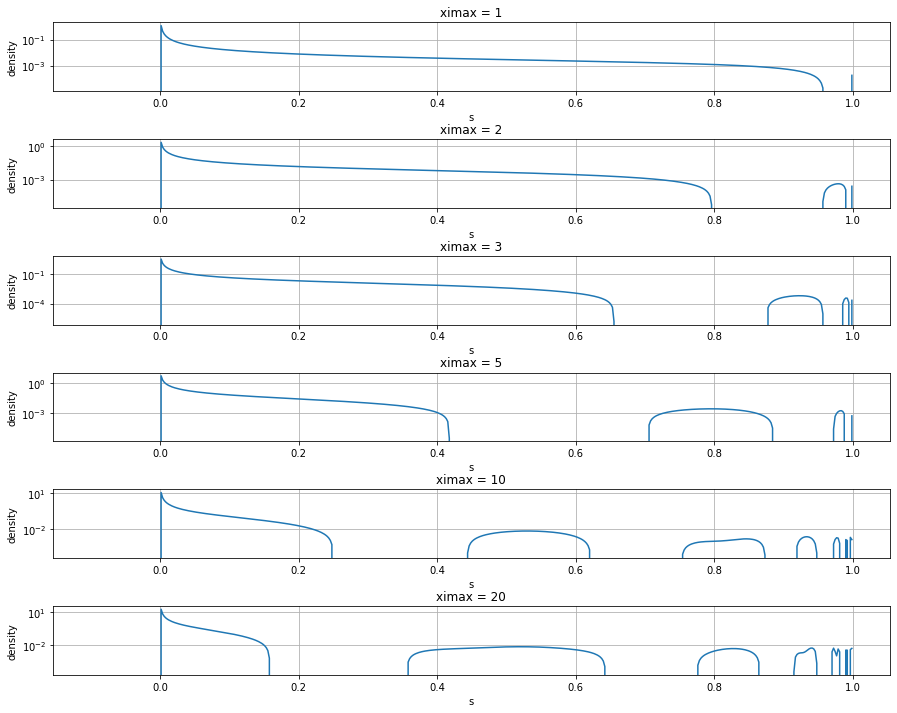

In [274]:
fig, ax = plt.subplots(6,1, figsize=(15,12))
fig.subplots_adjust(hspace=0.7)

for i,ximax in enumerate([1,2,3,5,10,20]):
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=ximax,nbreaks_xi=100)
    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax[i].plot(x,np.real(dfe))
    ax[i].grid()
    ax[i].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

$\to$ avec $\xi_{max}=2$, on n'est pas mauvais ! (est-ce seulement de la chance ?)

Un peu louche : on retrouve presque la même chose avec les données réelles qu'avec les données simulées... (mais pas tout à fait si ximax=10 par exemple)

Tracer im(dfe) au lieu de re(dfe): on trouve presque 0 : c'est ce à quoi on s'attendait !

# Vérification

## Moments


In [269]:
def get_mom(x,dist,k,dx):
    return sum([x[i]**k*np.real(dist[i])*dx for i in range(len(x))])

dx=1/len(x)


for ximax in [1,2,3,5,10,20]:
    print("\nximax=" + str(ximax))
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=ximax,nbreaks_xi=100)
    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    for i in range(5):
        print("ordre",i,":",get_mom(x,dfe,i,dx))


ximax=1
ordre 0 : 0.001481764906849845
ordre 1 : 0.0012515479427527834
ordre 2 : 0.00044883775245260044
ordre 3 : 0.00025646593555610144
ordre 4 : 0.0001640572444410839

ximax=2
ordre 0 : 0.001987502240819785
ordre 1 : 0.0018655778531438852
ordre 2 : 0.00045333597333814134
ordre 3 : 0.00018625894289514647
ordre 4 : 7.980333395228745e-05

ximax=3
ordre 0 : 0.0018409039783292467
ordre 1 : 0.002223165663168284
ordre 2 : 0.0003770265653159802
ordre 3 : 0.0001131543299821642
ordre 4 : 2.889166110573077e-05

ximax=5
ordre 0 : -0.0017260541870935872
ordre 1 : 0.0022982950018006518
ordre 2 : 0.0001464742444823002
ordre 3 : 3.835584695939045e-05
ordre 4 : 2.293272986568213e-05

ximax=10
ordre 0 : -0.010187976833695893
ordre 1 : 0.0033299445948640986
ordre 2 : 0.0001173739911514897
ordre 3 : 5.579506919302561e-05
ordre 4 : 3.030840291221164e-05

ximax=20
ordre 0 : -0.02788106523668274
ordre 1 : 0.003924184497803135
ordre 2 : 6.48883341825424e-05
ordre 3 : 9.71813774403734e-05
ordre 4 : 6.578657

## Erreur de régularisation

On trace les $a_{\xi}$ pour voir à partir de quel $\xi$ on peut les oublier.

In [117]:
ximin=0
ximax=50
nbreaks_xi=100
a_xi=[]
xi=[]
xi_axi=get_axi(growthR_sim,ximin,ximax,nbreaks_xi,tmax=100)
for xip,reaxi,imaxi in xi_axi:
    a_xi+=[reaxi+1j*imaxi]
    xi+=[xip]
    Ff=[a_xip/lambd+1 for a_xip in a_xi]

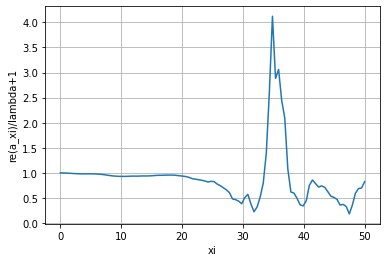

In [118]:
plt.grid()
plt.plot(xi,1+np.real(a_xi)/lambd)
plt.ylabel("re(a_xi)/lambda+1")
plt.xlabel("xi")
plt.show()

$\Re(Ff(\xi))=1+\frac{1}{\lambda}\Re(a_{\xi})$:

$\to$ plutôt pas bruité jusqu'à $\xi=30$;

$\to$ beaucoup de bruit à $\xi=35$;

$\to$ de toute manières, $\xi=35$ est une fréquence trop grande pour qu'on s'en préoccupe ?

$\to$ $Ff(\xi)$ ne tend jamais vers 0 : étonnant ?

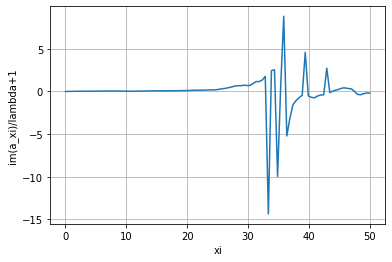

In [119]:
plt.grid()
plt.plot(xi,np.imag(a_xi)/lambd)
plt.ylabel("im(a_xi)/lambda+1")
plt.xlabel("xi")
plt.show()

$\Im(Ff(\xi))=\frac{1}{\lambda}\Im(a_{\xi})$:

$\to$ jusqu'à $\xi=25$ : très stable

$\to$ de nombreux pics (très localisés, nbreaks=1000 pour mieux les voir) : sans doute du bruit ? 

$\to$ On doit avoir $Ff(\xi)\to 0$ donc couper un peu avant $\xi=10$ ?


## DFE sur un plus grand domaine

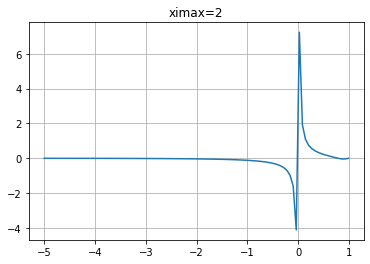

In [243]:
xmin_reel=-5
xmax_reel=0.99
nbreaks_x=100
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(np.array([1-xp for xp in x]))

dfeln=get_dfe(wt_sim,ximin=0,ximax=2,nbreaks_xi=100)

# on transforme f densité de ln(1-s) en g densité de 1-s:
# g(z)=f(ln z)/z
dfe=[dfeln[i]/x[i] for i in range(len(x))]
plt.grid()
plt.title("ximax=2")
plt.plot(x,np.real(dfe))

# Réplications sur des simulations différentes

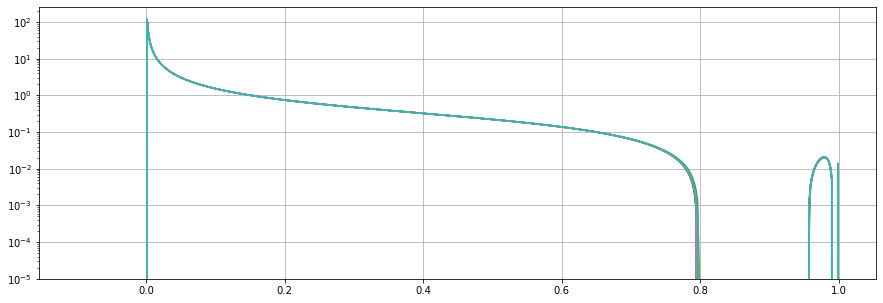

In [232]:
im, ax = plt.subplots(1,1, figsize=(15,5))

for growthR_sim_noise_i in growthR_sim_noise_rep:
    dfeln=get_dfe(growthR_sim_noise_i,ximin=0,ximax=2,nbreaks_xi=100)

    dfe=[dfeln[i]/x[i] for i in range(len(x))]
    ax.plot(x,np.real(dfe))

ax.grid()
plt.yscale('log')
plt.show()

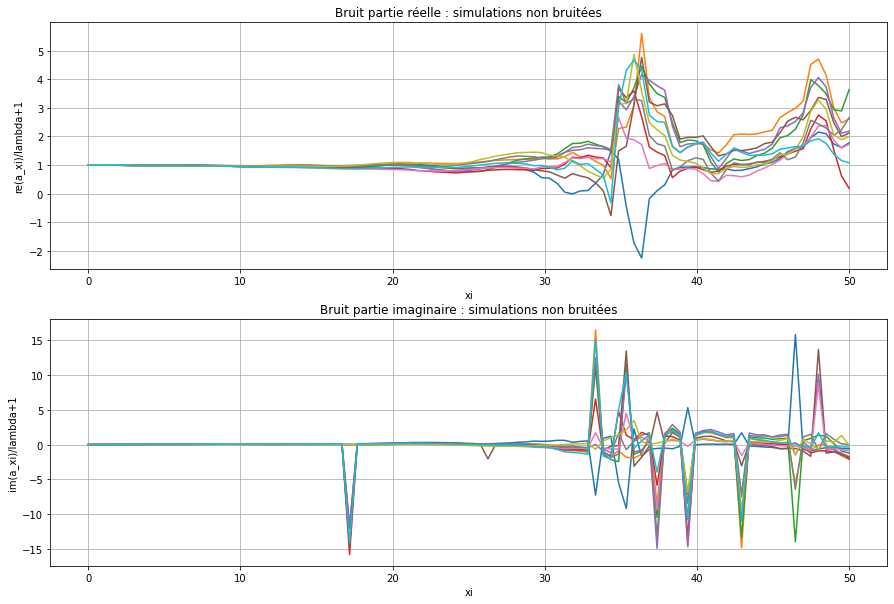

In [226]:
ximin=0
ximax=50
nbreaks_xi=100

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_i in growthR_sim_rep:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations non bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations non bruitées")
plt.show()

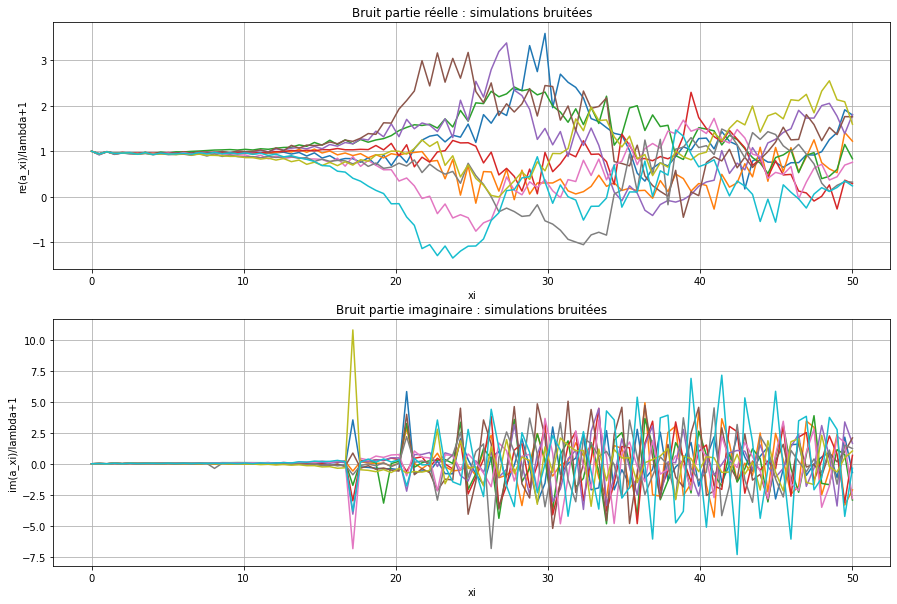

In [227]:
ximin=0
ximax=50
nbreaks_xi=100

im, ax = plt.subplots(2,1, figsize=(15,10))

for growthR_sim_noise_i in growthR_sim_noise_rep:
    a_xi=[]
    xi=[]
    xi_axi=get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=100)
    for xip,reaxi,imaxi in xi_axi:
        a_xi+=[reaxi+1j*imaxi]
        xi+=[xip]
        Ff=[a_xip/lambd+1 for a_xip in a_xi]
    
    ax[0].plot(xi,1+np.real(a_xi)/lambd)
    ax[1].plot(xi,np.imag(a_xi)/lambd)

ax[0].grid()
ax[1].grid()
ax[0].set(xlabel="xi", ylabel="re(a_xi)/lambda+1", title="Bruit partie réelle : simulations bruitées")
ax[1].set(xlabel="xi", ylabel="im(a_xi)/lambda+1", title="Bruit partie imaginaire : simulations bruitées")
plt.show()